In [2]:
import os
import sys

# print(os.getcwd())
# print(sys.path)
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))
# print(sys.path)

In [4]:
import src.Black_Scholes as Black_Scholes

/home/cloud/miniconda3/envs/pymc-env/lib/python3.11/site-packages/pymc/data.py:235: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, obs_sigma]
Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 1 seconds.


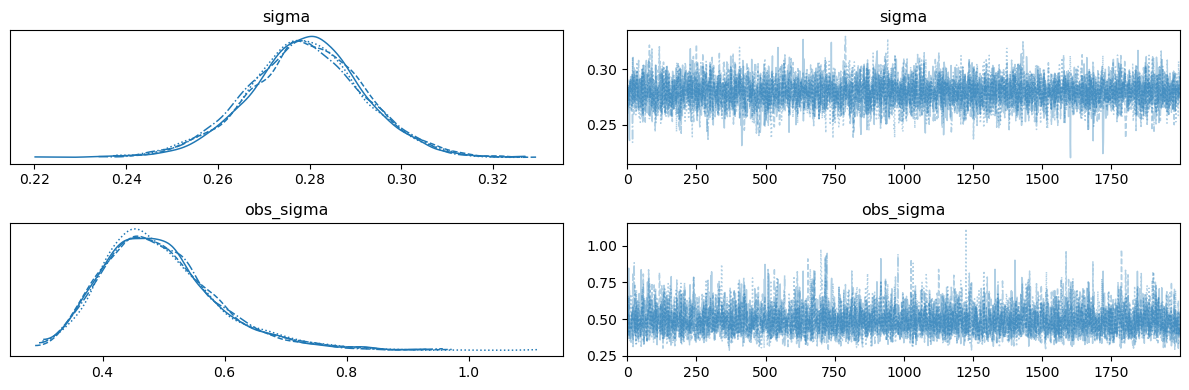


Bayesian estimated volatility: 0.2791 ± 0.0128
Yahoo mean implied volatility (filtered strikes): 0.2957


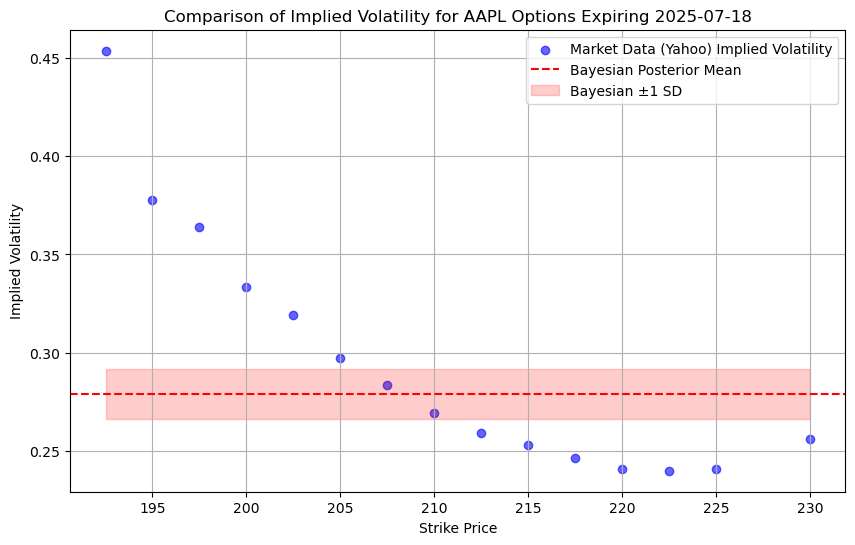

{'posterior_mean': 0.2791,
 'posterior_std': 0.0128,
 'yahoo_iv_mean': 0.29568575415039067,
 'expiry': '2025-07-18'}

In [5]:

ticker = "AAPL"
r = 0.01
Black_Scholes.implied_volatility_vs_market_data(ticker, expiry_date="2025-07-18", r=0.01)

/home/cloud/miniconda3/envs/pymc-env/lib/python3.11/site-packages/pymc/data.py:235: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, obs_sigma]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
/home/cloud/miniconda3/envs/pymc-env/lib/python3.11/site-packages/pymc/data.py:235: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, obs_sigma]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
/home/cloud/miniconda3/envs/pymc-env/lib/python3.11/site-packages/pymc/data.py:235: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data 

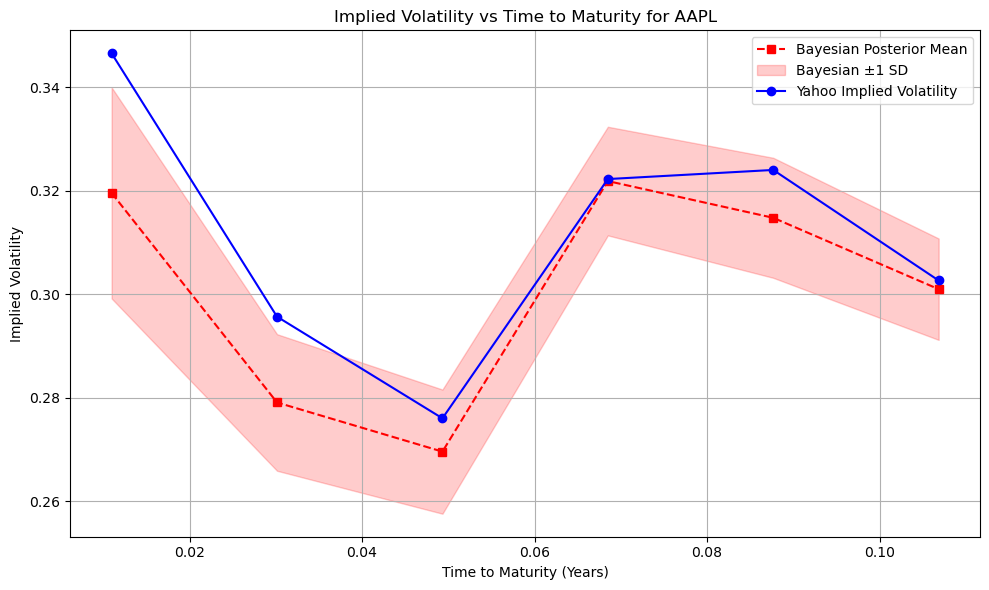

In [6]:
Black_Scholes.implied_volatility_vs_maturity(ticker, max_expiries=6, r=0.01)